In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# User types

## Representative users

In [4]:
valid['MeanActive'] = valid.Zeros.apply(np.mean)
valid['MedianActive'] = valid.Zeros.apply(np.median)
valid['MaxActive'] = valid.Zeros.apply(np.max)

valid = valid.sort_values('MeanActive', ascending=False)
valid = valid.reset_index(drop=True)
valid.head()

,UUID,Count,Duration,Zeros,DiffMean,DiffSD,DiffMedian,DiffMin,DiffMax,SDK,Locale,Timezone,Manufacturer,MeanActive,MedianActive,MaxActive
0,device.1792,739,22 days 23:42:32.281000,"[74, 76, 78, 78, 78, 79, 79, 69, 69, 69, 69, 7...",44.854388,129.134006,15.401883,0.023817,2833.496250,24,ko_KR,Asia/Seoul,samsung,70.534506,75.0,91
1,device.3803,1565,16 days 14:46:07.680000,"[34, 35, 35, 35, 37, 37, 38, 42, 43, 46, 45, 4...",15.298036,4.883241,15.000883,0.274083,104.744267,28,en_US,America/Denver,google,66.205112,67.0,109
2,device.0940,1150,16 days 11:14:35.795000,"[63, 67, 64, 64, 64, 64, 64, 65, 64, 68, 68, 6...",20.639336,17.290961,15.145567,0.038350,216.038150,25,es_US,America/Mexico_City,motorola,63.526957,64.0,160
3,device.0773,1909,22 days 17:39:03.882000,"[9, 9, 9, 14, 15, 17, 25, 23, 23, 25, 30, 31, ...",17.158839,15.903289,15.010117,0.046833,237.150467,26,en_GB,Asia/Riyadh,samsung,58.481928,51.0,126
4,device.0276,1504,18 days 02:43:29.234000,"[30, 29, 36, 38, 38, 38, 40, 41, 40, 40, 40, 4...",17.354283,18.615053,15.016617,0.036750,384.318317,27,en_US,America/New_York,samsung,56.416888,58.0,108


### Frequent Cleaners

device.1029


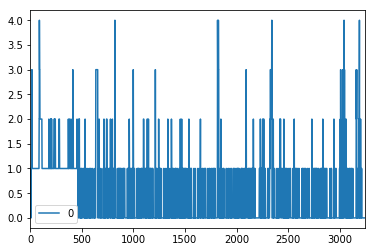

device.1531


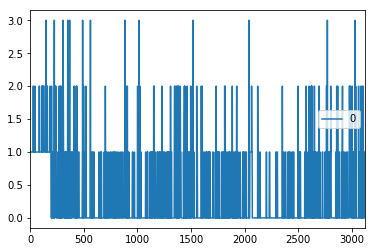

In [5]:
for index, row in valid[(valid.Count >= 3000) & (valid.MeanActive < 5) & (valid.MaxActive < 5)].head(3).iterrows():
    print(row['UUID'])
    pd.DataFrame(row['Zeros']).plot()
    plt.show()

### Contained Usage

device.2391


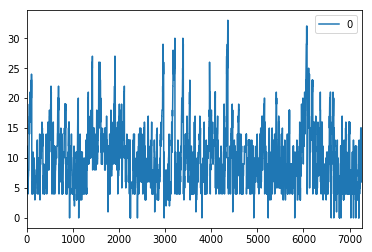

device.0094


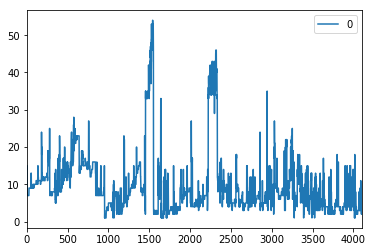

device.2890


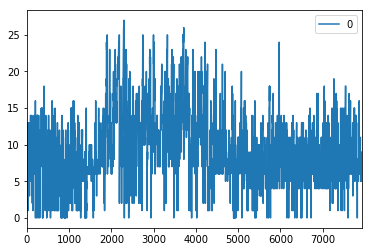

In [6]:
for index, row in valid[(valid.Count >= 3000) & (valid.MeanActive >= 5) & (valid.MeanActive < 10)].head(3).iterrows():
    print(row['UUID'])
    pd.DataFrame(row['Zeros']).plot()
    plt.show()

### Notification Hoarders

device.3714


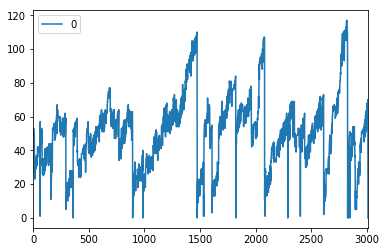

device.3265


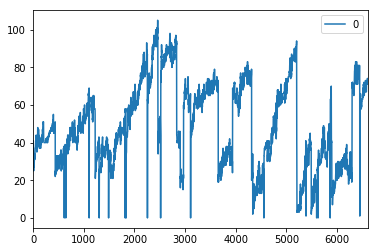

device.0954


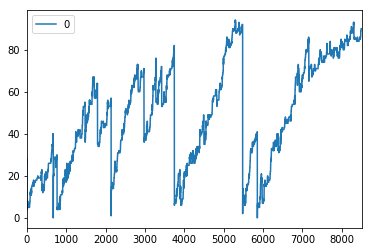

In [7]:
for index, row in valid[(valid.Count >= 3000) & (valid.MeanActive >= 10)].head(3).iterrows():
    print(row['UUID'])
    pd.DataFrame(row['Zeros']).plot()
    plt.show()

### Plot

In [8]:
LIMIT = 3000

def get_packages(lst):
    packages = []
    for n in lst:
        packages.append(n['packageName'])
    return packages

def has_non_clearable(lst):
    for n in lst:
        if not n['isClearable']:
            return True
    return False

# def filter_clearable(lst):
#     result = []
#     for n in lst:
#         if n['isClearable']:
#             result.append(n)
#     return result

def plot(uuid, label):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')[:LIMIT]
    df['ActiveCount'] = df.Active.apply(filter_active).apply(len)
    df['HasNonClearable'] = df.Active.apply(has_non_clearable)
    
    ax = df.ActiveCount.plot(
        kind='line',
        figsize=(6, 4),
        grid=True
    )
    
    # Ticks
    if label == 'frequent_cleaner':
        ax.set_yticks(range(0, 5, 1))
    if label == 'contained_usage':
        ax.set_yticks(range(0, 30, 5))
        ax.set_yticks(np.arange(0, 30, 2.5), minor=True)
    if label == 'notification_hoarder':
        ax.set_yticks(range(0, 120, 20))
        ax.set_yticks(range(0, 120, 10), minor=True)
        
    # Grid
    ax.set_axisbelow(True)
    ax.xaxis.grid(alpha=0.2, linestyle='dashed')
    ax.yaxis.grid(alpha=0.2, linestyle='dashed')
    
    # Tweak font sizes
    ax.set_xlabel('Snapshots', fontsize=10)
    ax.set_ylabel('Notifications (Grouped)', fontsize=10)
    ax.tick_params(labelsize=10)
    
    plt.gca().set_ylim(bottom=0)
    
    plt.savefig('figures/user_types_%s.png' % label, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.savefig('figures/user_types_%s.pdf' % label, bbox_inches='tight', pad_inches=0)

    plt.show()
    
    print(label)
    print(df.LocalTime.max() - df.LocalTime.min())
    print('%s snapshots' % len(df))
    
    print()
    
    print('Mean = %s [grouped!]' % np.round(df.ActiveCount.mean(), 2))
    print('SD   = %s' % np.round(df.ActiveCount.std(), 2))
    print('Md   = %s' % np.round(df.ActiveCount.median(), 2))
    print('Max notifications: %s' % df.ActiveCount.max())
    print('Non-clearable: %s%%' % np.round((len(df[df.HasNonClearable]) / len(df) * 100), 2))
    print('')
    
    numapps = df.Active.apply(get_packages)
    numapps = len(set(itertools.chain(*numapps)))
    print('%s apps' % numapps)

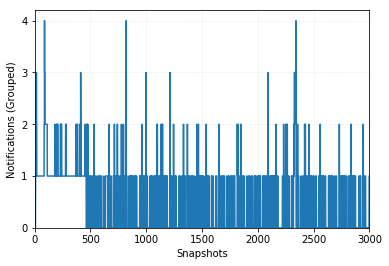

frequent_cleaner
36 days 17:31:43.985000
3000 snapshots

Mean = 0.48 [grouped!]
SD   = 0.62
Md   = 0.0
Max notifications: 4
Non-clearable: 37.67%

24 apps


In [9]:
plot('device.1029', 'frequent_cleaner')

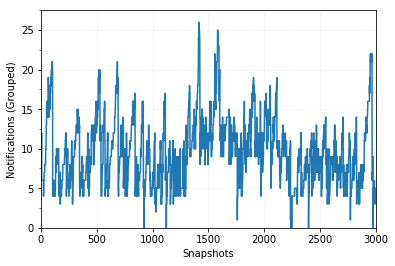

contained_usage
39 days 12:31:29.319000
3000 snapshots

Mean = 9.69 [grouped!]
SD   = 4.19
Md   = 9.0
Max notifications: 26
Non-clearable: 99.73%

23 apps


In [10]:
plot('device.2391', 'contained_usage')

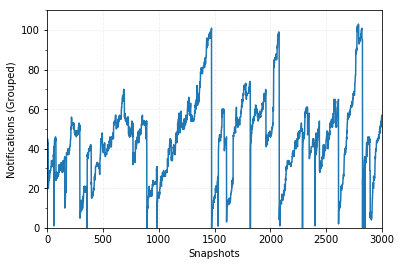

notification_hoarder
34 days 16:31:27.037000
3000 snapshots

Mean = 45.0 [grouped!]
SD   = 20.01
Md   = 45.0
Max notifications: 103
Non-clearable: 99.7%

97 apps


In [11]:
plot('device.3714', 'notification_hoarder')

## Overall stats

In [12]:
def get_packages(lst):
    packages = []
    for n in lst:
        packages.append(n['packageName'])
    return packages

def worker_get_user_features(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    active = df.Active.apply(filter_active).apply(len)
    
    apps = df.Active.apply(get_packages).tolist()
    apps = len(set(itertools.chain(*apps)))
            
    return pd.DataFrame({
        'UUID': uuid,
        'MeanActive': active.mean(),
        'MedianActive': active.median(),
        'MaxActive': active.max(),
        'Zeros': len(active[active == 0]) / len(active),
        'Apps': apps
    }, index=[0])

In [13]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_get_user_features, uuids)

users = pd.concat(lst)
users = users.reset_index(drop=True)
users.tail()

,UUID,MeanActive,MedianActive,MaxActive,Zeros,Apps
3948,device.1328,0.116976,0.0,6,0.950547,22
3949,device.3229,0.114913,0.0,3,0.904943,17
3950,device.3915,0.066329,0.0,3,0.951175,10
3951,device.0541,0.093878,0.0,3,0.919388,14
3952,device.2127,0.072555,0.0,12,0.970945,25


In [14]:
users.describe()

,MeanActive,MedianActive,MaxActive,Zeros,Apps
count,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000
mean,3.401013,2.835947,16.517582,0.219647,30.912472
std,4.588902,4.403697,14.223144,0.215737,13.813954
min,0.066329,0.000000,2.000000,0.000000,4.000000
25%,1.251316,1.000000,8.000000,0.018430,21.000000
50%,2.174066,2.000000,12.000000,0.156377,28.000000
75%,3.683864,3.000000,19.000000,0.377990,37.000000
max,61.277391,61.000000,155.000000,0.970945,111.000000


In [15]:
users.Apps.quantile(.95)

57.0

### Mean (Grouped)

In [16]:
users.MeanActive.describe()

count    3953.000000
mean        3.401013
std         4.588902
min         0.066329
25%         1.251316
50%         2.174066
75%         3.683864
max        61.277391
Name: MeanActive, dtype: float64

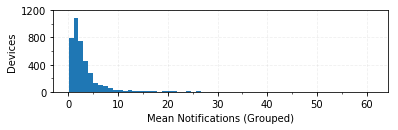

In [17]:
ax = users.MeanActive.hist(
    bins=int(np.ceil(users.MeanActive.max())),
    figsize=(6, 1.5),
    grid=True
)

# Ticks
ax.set_xticks(range(0, 65, 10))
ax.set_xticks(range(0, 65, 5), minor=True)
ax.set_yticks(range(0, 1300, 400))
ax.set_yticks(range(0, 1300, 200), minor=True)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Mean Notifications (Grouped)', fontsize=10)
ax.set_ylabel('Devices', fontsize=10)
ax.tick_params(labelsize=10)

plt.savefig('figures/mean_notifications_hist.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/mean_notifications_hist.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

In [18]:
print('Users with >20 mean active notifications (grouped):')
print(len(users[users.MeanActive > 20]))

Users with >20 mean active notifications (grouped):
62


### Median (Grouped)

In [19]:
users.MedianActive.describe()

count    3953.000000
mean        2.835947
std         4.403697
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        61.000000
Name: MedianActive, dtype: float64

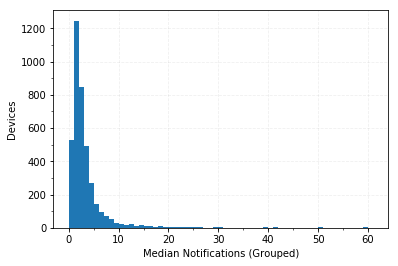

In [20]:
ax = users.MedianActive.hist(
    bins=int(np.ceil(users.MedianActive.max())),
    figsize=(6, 4),
    grid=True
)

# Ticks
ax.set_xticks(range(0, 65, 10))
ax.set_xticks(range(0, 65, 5), minor=True)
ax.set_yticks(range(0, 1300, 200))
ax.set_yticks(range(0, 1300, 100), minor=True)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Median Notifications (Grouped)', fontsize=10)
ax.set_ylabel('Devices', fontsize=10)
ax.tick_params(labelsize=10)

plt.savefig('figures/median_notifications_hist.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/median_notifications_hist.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

### Max (Grouped)

In [21]:
users.MaxActive.describe()

count    3953.000000
mean       16.517582
std        14.223144
min         2.000000
25%         8.000000
50%        12.000000
75%        19.000000
max       155.000000
Name: MaxActive, dtype: float64

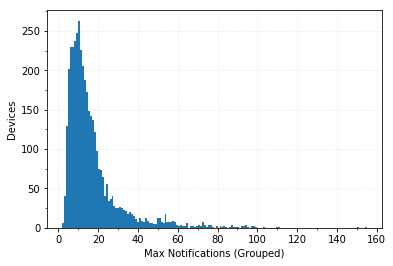

In [22]:
ax = users.MaxActive.hist(
    bins=int(np.ceil(users.MaxActive.max())),
    figsize=(6, 4),
    grid=True
)

# Ticks
ax.set_xticks(range(0, 170, 20))
ax.set_xticks(range(0, 170, 10), minor=True)
ax.set_yticks(range(0, 300, 50))
ax.set_yticks(range(0, 300, 25), minor=True)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Max Notifications (Grouped)', fontsize=10)
ax.set_ylabel('Devices', fontsize=10)
ax.tick_params(labelsize=10)

plt.savefig('figures/max_notifications_hist.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.savefig('figures/max_notifications_hist.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

### Zero Distribution (Grouped)

In [23]:
users.Zeros.describe()

count    3953.000000
mean        0.219647
std         0.215737
min         0.000000
25%         0.018430
50%         0.156377
75%         0.377990
max         0.970945
Name: Zeros, dtype: float64

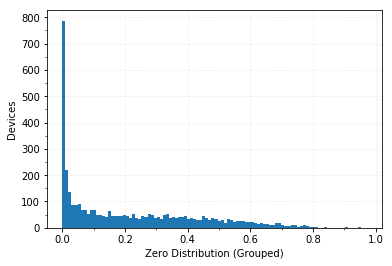

In [24]:
ax = users.Zeros.hist(
    bins=100,
    figsize=(6, 4),
    grid=True
)

# Ticks
ax.set_xticks(np.arange(0, 1.1, 0.2))
ax.set_xticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_yticks(range(0, 850, 100))
ax.set_yticks(range(0, 850, 50), minor=True)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Zero Distribution (Grouped)', fontsize=10)
ax.set_ylabel('Devices', fontsize=10)
ax.tick_params(labelsize=10)

plt.show()

### Apps

In [25]:
users.Apps.describe()

count    3953.000000
mean       30.912472
std        13.813954
min         4.000000
25%        21.000000
50%        28.000000
75%        37.000000
max       111.000000
Name: Apps, dtype: float64

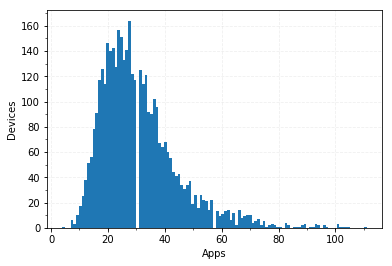

In [26]:
ax = users.Apps.hist(
    bins=int(np.ceil(users.Apps.max())),
    figsize=(6, 4),
    grid=True
)

# Ticks
ax.set_xticks(range(0, 120, 20))
ax.set_xticks(range(0, 120, 10), minor=True)
ax.set_yticks(range(0, 175, 20))
ax.set_yticks(range(0, 175, 10), minor=True)

# Grid
ax.set_axisbelow(True)
ax.xaxis.grid(alpha=0.2, linestyle='dashed')
ax.yaxis.grid(alpha=0.2, linestyle='dashed')

# Tweak font sizes
ax.set_xlabel('Apps', fontsize=10)
ax.set_ylabel('Devices', fontsize=10)
ax.tick_params(labelsize=10)

plt.show()